#### algom/playbooks
# Financial Prediction
__ETL pipeline for asset prices (OHLCV), standard indicators and engineered features.__


#### Resources
+ [Google BigQuery](https://console.cloud.google.com/bigquery?project=algomosaic-nyc&p=algomosaic-nyc&page=project)
+ [Google Storage](https://console.cloud.google.com/storage/browser/algom-trading?project=algomosaic-nyc)
+ [Google Drive](https://drive.google.com/drive/folders/1ou6vEWHHeVI0IIjdvj-zGYrCQ7KHRYRm)
+ [Trade Journal: Watchlist](https://docs.google.com/spreadsheets/d/1KXl8GxHlveYT5d3UifVwz-5-oxMyikgSfoZ1evIobmc/edit#gid=1679258225)


In [1]:
import sys
sys.path.append('/home/jovyan/algom-trading/src')


<br> 

## ETL
#### Run ETL process on a single asset and load to BigQuery

In [2]:
# %load_ext autoreload
# %reload_ext autoreload

In [4]:
# from etl import ticker_etl as ticker_etl

# # initialize the ETL process
# etl_process = ticker_etl.etl(
#     ticker='BTC-USD', 
#     start_date = '2010-07-01'
# )

# # get ticker indicators and features
# df = etl_process.get_ticker_etl(
#     ohlc_library = 'etl.get_ticker_data',
#     indicators_library = 'etl.get_indicators',
#     features_library = 'etl.get_feature_engineering'
# )

# # load to bigquery and preview
# etl_process.ticker_to_bigquery()
# df.head()


# specify ticker and other parameters
etl_process = ticker_etl.etl(
    ticker='BTC-USD', 
    start_date='2010-07-01',
)

# specify packages to apply (optional)
etl_process.ohlc_library = 'etl.get_ticker_data'
etl_process.indicators_library = 'etl.get_indicators'
etl_process.features_library = 'etl.get_feature_engineering'

# get ticker indicators and features
df = etl_process.get_ticker_etl()

# load to bigquery and preview
etl_process.ticker_to_bigquery()
df.tail()


/home/jovyan/algom-trading/src/etl/talib_features.py:159: RuntimeWarning: divide by zero encountered in log
  np.log( df[numerator].shift(numerator_shift) / df[denominator].shift(denominator_shift) ),


RUNNING: algomosaic-nyc:yahoo_features.features_BTC_USD_20191014 is being extracted and transformed.
Loaded dataframe to BigQuery in 0:01:07.719299:	algomosaic-nyc:yahoo_features.features_BTC_USD_20191014
SUCCESS: algomosaic-nyc:yahoo_features.features_BTC_USD_20191014 has been loaded to BigQuery. Runtime: 0:01:20.570061.


,As_of_Date,Date,Ticker,Week,Month,Quarter,Year,Day_of_Week,Day_of_Year,High,...,RATIO_Close_5_Close_10,RATIO_Close_5_Close_15,RATIO_Close_5_Close_30,RATIO_Close_10_Close_15,RATIO_Close_10_Close_30,RATIO_Close_10_Close_60,RATIO_Close_10_Close_90,RATIO_Close_15_Close_30,RATIO_Close_15_Close_60,RATIO_Close_15_Close_90
3372,2019-10-14,2019-10-09,BTC-USD,41,10,4,2019,2,282,8672.580078,...,0.982905,0.967504,0.808399,0.984332,0.822459,0.719939,0.704786,0.835551,0.731399,0.716004
3373,2019-10-14,2019-10-10,BTC-USD,41,10,4,2019,3,283,8834.110352,...,0.944956,0.974405,0.774058,1.031164,0.819147,0.731215,0.732723,0.794391,0.709116,0.710578
3374,2019-10-14,2019-10-11,BTC-USD,41,10,4,2019,4,284,8439.440430,...,0.978978,1.001677,0.787721,1.023186,0.804636,0.771847,0.822342,0.786403,0.754356,0.803707
3375,2019-10-14,2019-10-12,BTC-USD,41,10,4,2019,5,285,8498.589844,...,0.993400,0.996136,0.789784,1.002754,0.795032,0.822009,0.760009,0.792848,0.819751,0.757922
3376,2019-10-14,2019-10-14,BTC-USD,42,10,4,2019,0,287,8414.240234,...,1.052046,1.065454,0.829011,1.012745,0.787999,0.792360,0.866780,0.778082,0.782389,0.855872


<br> 

## Model
#### Train a predictive model on ETL output. Load results to BigQuery and Google Storage.

<br><br>

__Get data from BigQuery__

In [1]:
import sys
sys.path.append('/home/jovyan/algom-trading/src')


In [2]:
import pandas as pd
import numpy as np
from data_mgmt import bigquery_data as bqd

%reload_ext autoreload

file = '../queries/SPY_n20_train.sql'
# attribs = {'partition': "20190731"}
df = bqd.file_to_df(file, attribs)
# df = bqd.query_to_df(query)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df.head()


NameError: name 'attribs' is not defined

<br><br>

__Specify model type/parameters and train model__

In [5]:
# %load_ext autoreload
%reload_ext autoreload


In [3]:
from sklearn.ensemble import RandomForestRegressor
import model.model_regression as mg

model = mg.modelRegression(df, 'ROR_n10')
rf = RandomForestRegressor(
    n_estimators = 5,
    criterion='mae',
    random_state = 0,
    n_jobs=-1
)

model.set_omits(['ROR_n1', 'ROR_n3', 'ROR_n5', 'ROR_n10', 'ROR_n15', 'ROR_n20', 'ROR_n25', 'ROR_n30'])
model.model_description = 'Add description here.'

model.fit(rf)


Omit and features lists have been updated.
Model metadata added to `self.metadata.metadata`
Model metadata added to `self.metadata.parameters`
Set feature_importance to `self.feature_importance.feature_importance`
Fit model in 0:01:34.038841.


<br>

__Get model performance__

In [3]:
model.evaluate()
model.get_performance()


# MODEL PERFORMANCE SUMMARY | n20 | e = 20
#         + Mean Absolute Error:	 0.01458
#         + Error Variance:	 0.00044
#         + R-Squared:		 0.78337

# MODEL PERFORMANCE SUMMARY | n20 | e = 20
#         + Mean Absolute Error:	 0.01466
#         + Error Variance:	 0.00044
#         + R-Squared:		 0.78685

# MODEL PERFORMANCE SUMMARY | n20 | e = 40
#         + Mean Absolute Error:	 0.01445
#         + Error Variance:	 0.00042
#         + R-Squared:		 0.79337

# MODEL PERFORMANCE SUMMARY | n20 | e = 40
#         + Mean Absolute Error:	 0.01425
#         + Error Variance:	 0.00041
#         + R-Squared:		 0.80164

# MODEL PERFORMANCE SUMMARY | n20 | e = 40 | add features
#         + Mean Absolute Error:	 0.0122
#         + Error Variance:	 0.0003
#         + R-Squared:		 0.82809

# MODEL PERFORMANCE SUMMARY | n20 | e = 40 | add features
#         + Mean Absolute Error:	 0.01218
#         + Error Variance:	 0.0003
#         + R-Squared:		 0.82948

#=========================================================


# MODEL PERFORMANCE SUMMARY | n10 | e = 20
#         + Mean Absolute Error:	 0.01292
#         + Error Variance:	 0.00031
#         + R-Squared:		 0.66631


NameError: name 'model' is not defined

In [24]:
# dir(model.metadata.model_class)

<br><br>

### View model performance
View charts that show model performance from several views. 

```
self.plot_predictions_by_date(start_date, end_date)
self.plot_predictions_histogram(start_date, end_date)
self.plot_predictions_by_date(start_date, end_date)
self.plot_predictions_histogram(start_date, end_date)
```

In [5]:
# specify start/end dates (optional)
start_date = '2018-01-01'
end_date = '2020-01-01'
%matplotlib inline


PLOT: Predictions by Date
        To view over select time periods, run `self.plot_predictions_by_date(start_date, end_date)`
        
PLOT: Prediction Errors by Date
        To view over select time periods, run `self.plot_errors_by_date(start_date, end_date)`
        


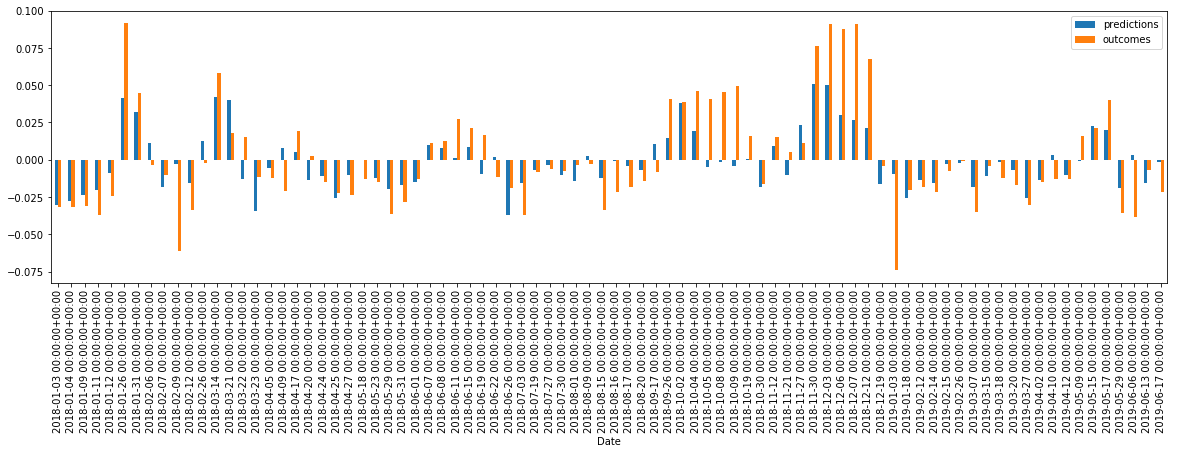

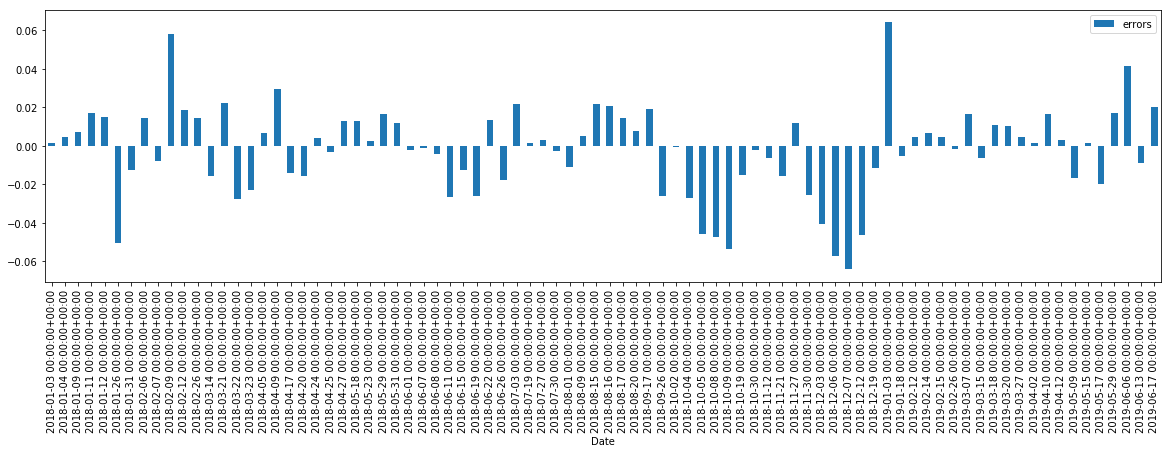

In [6]:
model.plot_predictions_by_date(start_date, end_date)
model.plot_errors_by_date(start_date, end_date)


PLOT: Predictions Histogram
        To view over select time periods, run `self.plot_predictions_histogram(start_date, end_date)`
        
PLOT: Predictions Histogram
        To view over select time periods, run `self.plot_errors_histogram(start_date, end_date)`
        


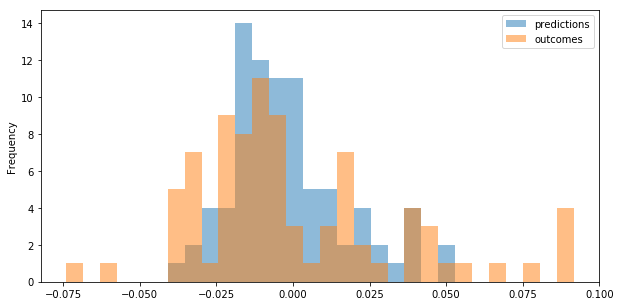

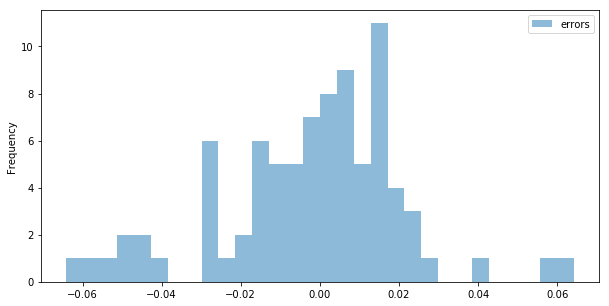

In [7]:
model.plot_predictions_histogram(start_date, end_date)
model.plot_errors_histogram(start_date, end_date)

PLOT: Predictions by Date
        To view over select time periods, run `self.plot_predictions_scatterplot(start_date, end_date)`
        


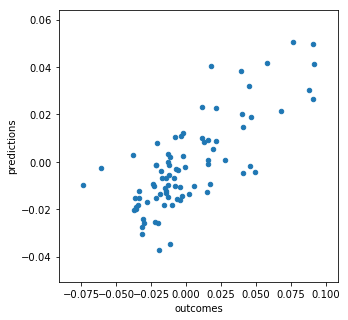

In [10]:
# import sys
# sys.path.append('/home/jovyan/algom-trading/src')

model.plot_predictions_scatterplot(start_date, end_date)


<br><br>

### Get feature importance

In [24]:
features = model.feature_importance.feature_importance
features.head(50)


,model_execution_id,data_id,outcome_variable,variable,importance
0,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,DIFF_AROR_10_AROR_150,0.01170
1,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,DIFF_AROR_5_AROR_10,0.01060
2,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RSI_100,0.01054
3,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_Low_2_Close_2,0.01048
4,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,DIFF_AROR_3_AROR_20,0.01030
5,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,SO_pct_k,0.01012
6,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_ATR_10_ATR_100,0.01006
7,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,DIFF_AROR_5_AROR_15,0.00996
8,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,AROR_90,0.00945
9,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,ATR_3,0.00945


In [23]:
features.tail(10)

,model_execution_id,data_id,outcome_variable,variable,importance
286,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_ATR_5_ATR_10,0.00100
287,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_Close_10_Close_30,0.00093
288,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,Acc_Dist_ROC_50,0.00091
289,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,AROR_10,0.00084
290,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,DIFF_AROR_5_AROR_50,0.00077
291,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,ATR_75,0.00076
292,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_Close_10_Close_90,0.00072
293,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,EMA_15,0.00067
294,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_Close_3_Close_15,0.00000
295,3d53c69a89fe3e468839af4857f7b828ae7ae7f8,f9bbfc1c48111e17ed48baa7035fd78489ba6c3b,ROR_n10,RATIO_High_2_Close_2,0.00000


In [5]:
# # top 100 featres
# [f for f in features['variable'][0:100]]

# list(model.feature_list)

# def plot_features_by_date(
#     df, 
#     feature, 
#     date='Date', 
#     start_date=None, 
#     end_date=None):
    
#     import pandas as pd
#     # get prediction data
#     output_data = df[[date, feature]].sort_values(by=date)
#     # index and filter on date
#     output_data = output_data.set_index('Date')
#     start_date = start_date or str(output_data.index.min())
#     end_date = end_date or str(output_data.index.max())
#     output_data = output_data[start_date : end_date]
#     # plot figure
#     print("""PLOT: {} by Date
#     To view over select time periods, run `plot_features_by_date(df, feature, start_date, end_date)`
#     """)
#     output_plot = output_data.plot(kind='line', figsize=(20,5))
#     return output_plot

# import data_mgmt


# def plot_features(
def plot_features_by_date(
    df, 
    y, 
    x='Date',
    date='Date', 
    start_date=None, 
    end_date=None):

    import pandas as pd
    # get prediction data
    output_data = df[[date, y, x]].sort_values(by=date)
    # index and filter on date
    output_data = output_data.set_index(date)
    start_date = start_date or str(output_data.index.min())
    end_date = end_date or str(output_data.index.max())
    output_data = output_data[start_date : end_date]
    # plot figure
    output_plot = output_data.plot(kind='line', figsize=(20,5))


    print("""PLOT: {} by {}, between {} and {}
    `plot_features_by_date(df, feature, start_date, end_date)`
    """.format(y, x, start_date, end_date))
    return output_plot




In [6]:
start_date = '2018-01-01'
end_date = '2020-01-01'

from data_mgmt import data_mgmt as dm

dm.plot_features_by_date(df = model.df, date = 'Date', feature = 'RSI_10',
    start_date=start_date, end_date=end_date
)


dm.plot_features_by_date(df = model.df, date = 'Date', feature = 'RSI_100',
    start_date=start_date, end_date=end_date
)

dm.plot_features_by_date(df = model.df, date = 'Date', feature = 'Adj_Close',
    start_date=start_date, end_date=end_date
)



NameError: name 'model' is not defined

In [17]:
# model.df.head()

# plot_features(
#     df = model.df,
#     x = 'Date',
#     y = 'Bollinger_pct_b_50',
#     chart_type = 'line'
# )

# list(model.df)


<br><br>

__Load model metadata and results to BigQuery__

In [36]:
model.load_to_bq()


yahoo_model_predictions.model_prediction does not exist. Skipping.


/opt/conda/lib/python3.7/site-packages/pandas/io/gbq.py:162: FutureWarning: private_key is deprecated and will be removed in a future version.Use the credentials argument instead. See https://pandas-gbq.readthedocs.io/en/latest/howto/authentication.html for examples on using the credentials argument with service account keys.
  credentials=credentials, verbose=verbose, private_key=private_key)


Loaded dataframe to BigQuery in 0:00:06.091627.
	algomosaic-nyc:yahoo_model_predictions.model_evaluation
Loaded dataframe to BigQuery in 0:00:06.220046.
	algomosaic-nyc:yahoo_model_performance.model_performance
Loaded dataframe to BigQuery in 0:00:05.585883.
	algomosaic-nyc:yahoo_model_metadata.model_metadata
Loaded dataframe to BigQuery in 0:00:03.449510.
	algomosaic-nyc:yahoo_model_metadata.model_parameters
Loaded dataframe to BigQuery in 0:00:05.597527.
	algomosaic-nyc:yahoo_model_feature_importance.model_features_importance
COMPLETE: all model outputs have been loaded to BigQuery!


<br><br>

__Pickle and store model in GCS.__

Option to add the following parameters:

```
model.storage.load_to_storage(
    bucket_name = "algom-trading", 
    blob_path = "models/sp500/")
```

In [19]:
import model.model_mgmt as mm
model.storage = mm.modelStorage(model)
model.storage.pickle_model(model_path="../models/", to_gcs=True)


Dumped model to:
	../models/20190731_RandomForestRegressor_SPY_9e25ff953bf9b4b1b9723af25a4fda4d9a919424.joblib
Uploaded pickle to Google Storage:
	https://storage.googleapis.com/algom-trading/models/20190731_RandomForestRegressor_SPY_9e25ff953bf9b4b1b9723af25a4fda4d9a919424.joblib


<br><br><br>

## Predict
#### Predit on new data as a backfill or future projection.


<br>

##### Get model from Google Storage.

In [1]:
import sys
sys.path.append('/home/jovyan/algom-trading/src')


In [2]:
from data_mgmt import bigquery_data as bqd
import numpy as np

query = """
SELECT *,
safe_divide(ATR_3, ATR_5)   as RATIO_ATR_3_ATR_5,
safe_divide(ATR_3, ATR_10)  as RATIO_ATR_3_ATR_10,
safe_divide(ATR_3, ATR_25)  as RATIO_ATR_3_ATR_25,
safe_divide(ATR_3, ATR_50)  as RATIO_ATR_3_ATR_50,
safe_divide(ATR_3, ATR_100) as RATIO_ATR_3_ATR_100,

safe_divide(ATR_5, ATR_10)  as RATIO_ATR_5_ATR_10,
safe_divide(ATR_5, ATR_25)  as RATIO_ATR_5_ATR_25,
safe_divide(ATR_5, ATR_50)  as RATIO_ATR_5_ATR_50,
safe_divide(ATR_5, ATR_100) as RATIO_ATR_5_ATR_100,

safe_divide(ATR_10, ATR_25)  as RATIO_ATR_10_ATR_25,
safe_divide(ATR_10, ATR_50)  as RATIO_ATR_10_ATR_50,
safe_divide(ATR_10, ATR_100) as RATIO_ATR_10_ATR_100,
safe_divide(ATR_10, ATR_150) as RATIO_ATR_10_ATR_150,

safe_divide(ATR_25, ATR_50)  as RATIO_ATR_25_ATR_50,
safe_divide(ATR_25, ATR_100) as RATIO_ATR_25_ATR_100,
safe_divide(ATR_25, ATR_150) as RATIO_ATR_25_ATR_150,
safe_divide(ATR_50, ATR_100) as RATIO_ATR_50_ATR_100,
safe_divide(ATR_50, ATR_150) as RATIO_ATR_50_ATR_150

FROM `algomosaic-nyc.yahoo_features.features_SPY_20190730`
WHERE `Date` >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY)
"""
df = bqd.bq_to_df(query)
df = df.replace([np.inf, -np.inf], np.nan)
# df = df.dropna()
df.head()


/opt/conda/lib/python3.7/site-packages/pandas/io/gbq.py:149: FutureWarning: private_key is deprecated and will be removed in a future version.Use the credentials argument instead. See https://pandas-gbq.readthedocs.io/en/latest/howto/authentication.html for examples on using the credentials argument with service account keys.
  credentials=credentials, verbose=verbose, private_key=private_key)


Loaded query to dataframe in 0:00:04.685762.


,As_of_Date,Date,Ticker,Week,Month,Quarter,Year,Day_of_Week,Day_of_Year,High,...,RATIO_ATR_5_ATR_100,RATIO_ATR_10_ATR_25,RATIO_ATR_10_ATR_50,RATIO_ATR_10_ATR_100,RATIO_ATR_10_ATR_150,RATIO_ATR_25_ATR_50,RATIO_ATR_25_ATR_100,RATIO_ATR_25_ATR_150,RATIO_ATR_50_ATR_100,RATIO_ATR_50_ATR_150
0,2019-07-30,2019-07-03 00:00:00+00:00,SPY,27,7,3,2019,2,184,298.820007,...,0.795183,0.911883,0.847172,0.795314,0.767370,0.929036,0.872167,0.841523,0.938787,0.905802
1,2019-07-30,2019-07-05 00:00:00+00:00,SPY,27,7,3,2019,4,186,298.640015,...,0.841655,0.935335,0.873759,0.821132,0.792267,0.934167,0.877902,0.847040,0.939769,0.906733
2,2019-07-30,2019-07-08 00:00:00+00:00,SPY,28,7,3,2019,0,189,298.260010,...,0.814699,0.930862,0.866643,0.811990,0.782424,0.931011,0.872299,0.840537,0.936937,0.902821
3,2019-07-30,2019-07-09 00:00:00+00:00,SPY,28,7,3,2019,1,190,297.519989,...,0.776367,0.919605,0.851003,0.793883,0.763644,0.925400,0.863287,0.830404,0.932880,0.897346
4,2019-07-30,2019-07-10 00:00:00+00:00,SPY,28,7,3,2019,2,191,299.660004,...,0.798464,0.930588,0.862537,0.803957,0.772820,0.926874,0.863924,0.830465,0.932083,0.895985


In [3]:
model_pickle_path = "algom-trading/models/20190731_RandomForestRegressor_SPY_9e25ff953bf9b4b1b9723af25a4fda4d9a919424.joblib"


In [4]:
import model.model_regression as mg
model = mg.modelRegression(df, 'ROR_n20')
model.set_omits(['ROR_n1', 'ROR_n3', 'ROR_n5', 'ROR_n10', 'ROR_n15', 'ROR_n20', 'ROR_n25', 'ROR_n30'])

import model.model_mgmt as mm
model.storage = mm.modelStorage(model)
model.storage.set_model_storage_path(model_pickle_path)
model.model = model.storage.get_model_from_storage()


Omit and features lists have been updated.
Downloaded file from GCS:
	20190731_RandomForestRegressor_SPY_9e25ff953bf9b4b1b9723af25a4fda4d9a919424.joblib


<br>

##### Score complete dataset and get performance metrics

In [11]:
model.to_bq = True
model.predict()
# model.predictions.head()

Model metadata added to `self.metadata.metadata`


/opt/conda/lib/python3.7/site-packages/pandas/io/gbq.py:162: FutureWarning: private_key is deprecated and will be removed in a future version.Use the credentials argument instead. See https://pandas-gbq.readthedocs.io/en/latest/howto/authentication.html for examples on using the credentials argument with service account keys.
  credentials=credentials, verbose=verbose, private_key=private_key)


Loaded dataframe to BigQuery in 0:00:03.893115.
	algomosaic-nyc:yahoo_model_metadata.model_metadata
Model metadata added to `self.metadata.parameters`
Loaded dataframe to BigQuery in 0:00:07.515116.
	algomosaic-nyc:yahoo_model_metadata.model_parameters
Mean Absolute Error: nan
Set predictions to self.predict in 0:00:00.112443.
Loaded dataframe to BigQuery in 0:00:05.094096.
	algomosaic-nyc:yahoo_model_predictions.model_prediction


In [12]:
model.get_performance()


R-Squared cannot be calculated.
Input contains NaN, infinity or a value too large for dtype('float64').
Mean Absolute Error nan.
Mean Absolute Error added to `self.mae`
Error Variance nan .
Mean Error Variance added to `self.error_var`
Performance metrics added to `self.performance`

MODEL PERFORMANCE SUMMARY
        + Mean Absolute Error:	 nan
        + Error Variance:	 nan
        + R-Squared:		 nan
        
PLOT PREDICTIONS: Use the following commands to view model performance.
        `self.plot_predictions_by_date(start_date, end_date)`
        `self.plot_predictions_histogram(start_date, end_date)`
        `self.plot_errors_by_date(start_date, end_date)`
        `self.plot_errors_histogram(start_date, end_date)`
        


/opt/conda/lib/python3.7/site-packages/pandas/io/gbq.py:162: FutureWarning: private_key is deprecated and will be removed in a future version.Use the credentials argument instead. See https://pandas-gbq.readthedocs.io/en/latest/howto/authentication.html for examples on using the credentials argument with service account keys.
  credentials=credentials, verbose=verbose, private_key=private_key)


Loaded dataframe to BigQuery in 0:00:04.557340.
	algomosaic-nyc:yahoo_model_performance.model_performance


In [13]:
start_date = '2019-01-01'
end_date = '2020-01-01'
%matplotlib inline

PLOT: Predictions by Date
        To view over select time periods, run `self.plot_predictions_by_date(start_date, end_date)`
        


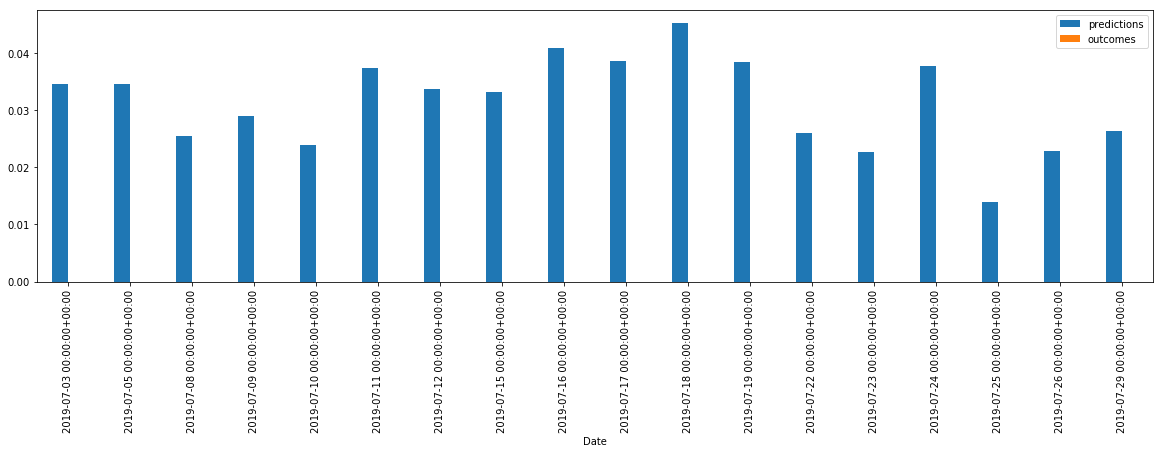

In [14]:

model.plot_predictions_by_date(start_date, end_date)
